<a href="https://colab.research.google.com/github/ChinmayNakwa/Image_Segmentation/blob/main/Cracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install timm
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="zrTfNs2Xx5ATQrPmKETi")
project = rf.workspace("chinmay-k5q2n").project("cracks-3ii36-9y2y7")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cracks-1 in coco:: 100%|██████████| 14805/14805 [00:04<00:00, 3490.08it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoProcessor, CLIPSegForImageSegmentation

In [ ]:
import json
from pathlib import Path
import numpy as np

def verify_roboflow_segmentation(dataset_path="cracks-1"):
    """Quick verification of Roboflow export"""
    dataset_path = Path(dataset_path)

    print("🔍 ROBOFLOW DATASET VERIFICATION")
    print("="*60)

    # Check all splits
    for subset in ['train', 'valid', 'test']:
        json_file = dataset_path / subset / "_annotations.coco.json"

        if not json_file.exists():
            print(f"❌ {subset}: annotations not found at {json_file}")
            continue

        with open(json_file, 'r') as f:
            coco = json.load(f)

        # Quick stats
        n_images = len(coco['images'])
        n_annotations = len(coco['annotations'])

        # Check segmentation format
        seg_types = []
        polygon_counts = []

        for ann in coco['annotations']:
            if 'segmentation' in ann and ann['segmentation']:
                seg = ann['segmentation']
                seg_types.append(type(seg).__name__)

                if isinstance(seg, list) and len(seg) > 0:
                    # Count polygon vertices
                    first_poly = seg[0]
                    if isinstance(first_poly, list):
                        polygon_counts.append(len(first_poly) // 2)

        print(f"\n📁 {subset.upper()} SET:")
        print(f"   Images: {n_images}")
        print(f"   Annotations: {n_annotations}")
        print(f"   Avg annotations/image: {n_annotations/n_images:.2f}")

        if polygon_counts:
            print(f"   ✅ SEGMENTATION DETECTED:")
            print(f"      - Polygons found: {len(polygon_counts)}")
            print(f"      - Avg vertices per polygon: {np.mean(polygon_counts):.1f}")
            print(f"      - Vertex range: {min(polygon_counts)} - {max(polygon_counts)}")

            # Sample annotation
            sample = coco['annotations'][0]
            print(f"\n   📝 Sample annotation structure:")
            print(f"      Keys: {list(sample.keys())}")
            if 'segmentation' in sample and sample['segmentation']:
                print(f"      Segmentation type: Polygon list")
                print(f"      Number of polygons: {len(sample['segmentation'])}")
        else:
            print(f"   ⚠️ NO POLYGON DATA FOUND")

    print("\n" + "="*60)

verify_roboflow_segmentation("cracks-1")

🔍 ROBOFLOW DATASET VERIFICATION

📁 TRAIN SET:
   Images: 14145
   Annotations: 22114
   Avg annotations/image: 1.56
   ✅ SEGMENTATION DETECTED:
      - Polygons found: 22016
      - Avg vertices per polygon: 62.4
      - Vertex range: 4 - 842

   📝 Sample annotation structure:
      Keys: ['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd']
      Segmentation type: Polygon list
      Number of polygons: 1

📁 VALID SET:
   Images: 318
   Annotations: 560
   Avg annotations/image: 1.76
   ✅ SEGMENTATION DETECTED:
      - Polygons found: 557
      - Avg vertices per polygon: 52.8
      - Vertex range: 4 - 842

   📝 Sample annotation structure:
      Keys: ['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd']
      Segmentation type: Polygon list
      Number of polygons: 1

📁 TEST SET:
   Images: 334
   Annotations: 548
   Avg annotations/image: 1.64
   ✅ SEGMENTATION DETECTED:
      - Polygons found: 542
      - Avg vertices per polygon: 60.

In [ ]:
from pathlib import Path

current_dir = Path('.')
dataset_folders = [d for d in current_dir.iterdir() if d.is_dir()]

print("📂 Available folders:")
for folder in sorted(dataset_folders):
    print(f"   - {folder.name}")

crack_folders = [d for d in dataset_folders if 'crack' in d.name.lower()]
if crack_folders:
    print(f"\n🎯 Crack-related folders found:")
    for folder in crack_folders:
        print(f"   - {folder.name}")

📂 Available folders:
   - .config
   - cracks-1
   - sample_data

🎯 Crack-related folders found:
   - cracks-1


In [ ]:
def create_masks_from_coco(dataset_root_path, visualize_samples=5):
    """
    Create binary masks from COCO segmentation annotations

    Args:
        dataset_root_path: Path to dataset root
        visualize_samples: Number of samples to visualize per subset (0 to disable)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    dataset_path = Path(dataset_root_path)
    subsets = ['train', 'valid', 'test']

    stats = {'total': 0, 'with_polygons': 0, 'bbox_fallback': 0, 'empty': 0}

    for subset in subsets:
        json_file = dataset_path / subset / "_annotations.coco.json"
        if not json_file.exists():
            print(f"⚠️ Skipping {subset}: annotations not found")
            continue

        print(f"\n{'='*50}")
        print(f"Processing {subset} set...")
        print(f"{'='*50}")

        with open(json_file, 'r') as f:
            coco = json.load(f)

        mask_dir = dataset_path / subset / "masks"
        mask_dir.mkdir(exist_ok=True)

        # Create visualization directory
        if visualize_samples > 0:
            viz_dir = dataset_path / subset / "visualizations"
            viz_dir.mkdir(exist_ok=True)

        img_map = {img['id']: img for img in coco['images']}

        # Group annotations by image_id
        img_annotations = {}
        for ann in coco['annotations']:
            img_annotations.setdefault(ann['image_id'], []).append(ann)

        subset_stats = {'images': len(img_map), 'polygons': 0, 'bbox': 0, 'empty': 0}
        visualized = 0

        for img_id, img_info in tqdm(img_map.items(), desc=f"{subset}"):
            file_name = img_info['file_name']
            W, H = img_info['width'], img_info['height']

            mask = Image.new('L', (W, H), 0)
            draw = ImageDraw.Draw(mask)

            has_annotations = False
            used_polygon = False

            if img_id in img_annotations:
                for ann in img_annotations[img_id]:
                    # Try polygon segmentation first
                    if 'segmentation' in ann and ann['segmentation']:
                        for seg in ann['segmentation']:
                            if len(seg) >= 6:  # Need at least 3 points (x,y pairs)
                                poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                                draw.polygon(poly, fill=255)
                                has_annotations = True
                                used_polygon = True

                    # Fallback to bbox only if no valid segmentation
                    elif 'bbox' in ann:
                        x, y, w_box, h_box = ann['bbox']
                        draw.rectangle([x, y, x + w_box, y + h_box], fill=255)
                        has_annotations = True
                        subset_stats['bbox'] += 1

            # Update statistics
            if has_annotations:
                if used_polygon:
                    subset_stats['polygons'] += 1
                stats['total'] += 1
                stats['with_polygons'] += (1 if used_polygon else 0)
                stats['bbox_fallback'] += (1 if not used_polygon else 0)
            else:
                subset_stats['empty'] += 1
                stats['empty'] += 1

            base_name = Path(file_name).stem
            mask.save(mask_dir / f"{base_name}.png")

            # VISUALIZATION
            if visualize_samples > 0 and visualized < visualize_samples and has_annotations:
                img_path = dataset_path / subset / file_name

                if img_path.exists():
                    try:
                        original = Image.open(img_path).convert('RGB')

                        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                        # Original image
                        axes[0].imshow(original)
                        axes[0].set_title(f'Original\n{file_name}', fontsize=10)
                        axes[0].axis('off')

                        # Mask
                        axes[1].imshow(mask, cmap='gray')
                        n_anns = len(img_annotations.get(img_id, []))
                        axes[1].set_title(f'Mask\n{n_anns} annotation(s)', fontsize=10)
                        axes[1].axis('off')

                        # Overlay
                        overlay = original.copy()
                        mask_array = np.array(mask)

                        # Create colored overlay
                        overlay_array = np.array(overlay).astype(float)
                        red_overlay = np.zeros_like(overlay_array)
                        red_overlay[:, :, 0] = 255  # Red channel

                        # Blend where mask is present
                        alpha = 0.4
                        mask_bool = mask_array > 0
                        overlay_array[mask_bool] = (
                            alpha * red_overlay[mask_bool] +
                            (1 - alpha) * overlay_array[mask_bool]
                        )

                        axes[2].imshow(overlay_array.astype(np.uint8))
                        axes[2].set_title('Overlay (Red = Crack)', fontsize=10)
                        axes[2].axis('off')

                        plt.tight_layout()
                        plt.savefig(viz_dir / f"{base_name}_viz.png", dpi=100, bbox_inches='tight')
                        plt.close()

                        visualized += 1
                    except Exception as e:
                        print(f"⚠️ Could not visualize {file_name}: {e}")

        # Print subset statistics
        print(f"\n📊 {subset.upper()} Statistics:")
        print(f"   Total images: {subset_stats['images']}")
        print(f"   ✅ With polygon masks: {subset_stats['polygons']} ({subset_stats['polygons']/subset_stats['images']*100:.1f}%)")
        if subset_stats['bbox'] > 0:
            print(f"   ⚠️ Bbox fallback: {subset_stats['bbox']}")
        if subset_stats['empty'] > 0:
            print(f"   ❌ Empty masks: {subset_stats['empty']}")
        if visualize_samples > 0:
            print(f"   📸 Visualizations created: {visualized}")

    # Overall summary
    print(f"\n{'='*50}")
    print(f"✅ GENERATION COMPLETE")
    print(f"{'='*50}")
    print(f"Total masks generated: {stats['total']}")
    print(f"✅ Polygon-based: {stats['with_polygons']} ({stats['with_polygons']/max(stats['total'],1)*100:.1f}%)")
    if stats['bbox_fallback'] > 0:
        print(f"⚠️ Bbox fallback: {stats['bbox_fallback']}")
    if stats['empty'] > 0:
        print(f"❌ Empty masks: {stats['empty']}")

    return stats

stats = create_masks_from_coco("cracks-1", visualize_samples=5)


Processing train set...


train: 100%|██████████| 14145/14145 [00:25<00:00, 555.23it/s]



📊 TRAIN Statistics:
   Total images: 14145
   ✅ With polygon masks: 14139 (100.0%)
   ⚠️ Bbox fallback: 98
   📸 Visualizations created: 5

Processing valid set...


valid: 100%|██████████| 318/318 [00:02<00:00, 128.94it/s]



📊 VALID Statistics:
   Total images: 318
   ✅ With polygon masks: 318 (100.0%)
   ⚠️ Bbox fallback: 3
   📸 Visualizations created: 5

Processing test set...


test: 100%|██████████| 334/334 [00:02<00:00, 132.84it/s]


📊 TEST Statistics:
   Total images: 334
   ✅ With polygon masks: 334 (100.0%)
   ⚠️ Bbox fallback: 6
   📸 Visualizations created: 5

✅ GENERATION COMPLETE
Total masks generated: 14797
✅ Polygon-based: 14791 (100.0%)
⚠️ Bbox fallback: 6


### Visualize Image and Generated Mask

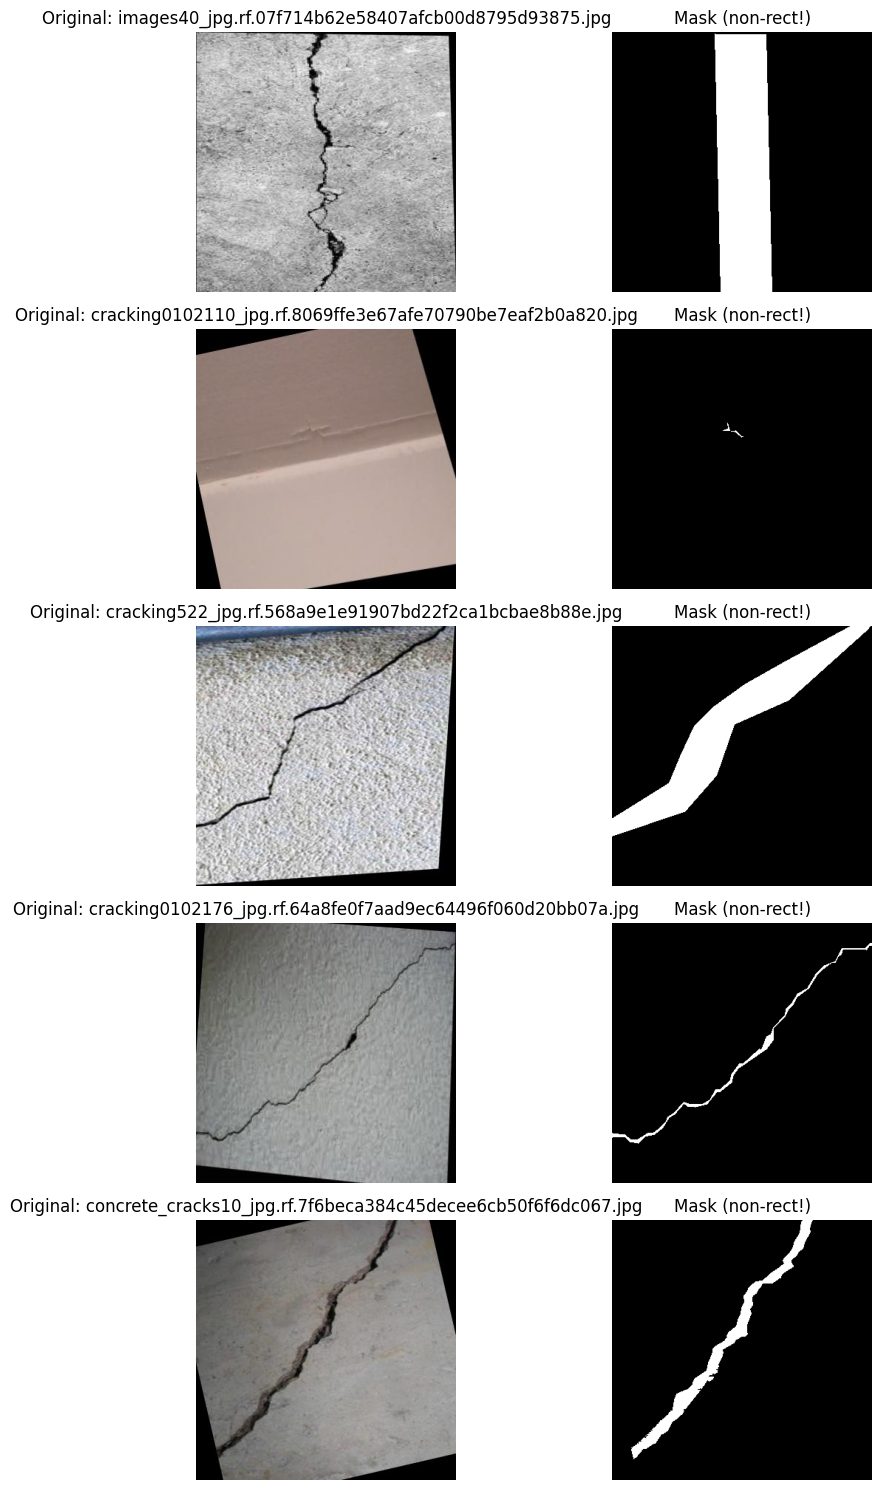

✅ Quality check saved!


In [ ]:
def quick_mask_check(dataset_path="cracks-1", num_samples=5):
    """Randomly check a few masks"""
    import random
    from PIL import Image
    import matplotlib.pyplot as plt

    dataset_path = Path(dataset_path)

    for subset in ['train']:
        mask_dir = dataset_path / subset / "masks"
        img_dir = dataset_path / subset

        mask_files = list(mask_dir.glob("*.png"))
        samples = random.sample(mask_files, min(num_samples, len(mask_files)))

        fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*3))

        for idx, mask_file in enumerate(samples):
            img_name = mask_file.stem + ".jpg"
            img_path = img_dir / img_name

            if not img_path.exists():
                img_path = img_dir / (mask_file.stem + ".png")

            if img_path.exists():
                img = Image.open(img_path)
                mask = Image.open(mask_file)

                axes[idx, 0].imshow(img)
                axes[idx, 0].set_title(f"Original: {img_name}")
                axes[idx, 0].axis('off')

                axes[idx, 1].imshow(mask, cmap='gray')
                axes[idx, 1].set_title(f"Mask (non-rect!)")
                axes[idx, 1].axis('off')

        plt.tight_layout()
        plt.savefig(dataset_path / "mask_quality_check.png", dpi=150)
        plt.show()
        print(f"✅ Quality check saved!")

quick_mask_check("cracks-1")

### Visualize an image with its segmentation mask overlay

In [ ]:
def show_overlay(dataset_root_path, subset='train', alpha=0.5):
    path = Path(dataset_root_path) / subset
    image_files = list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))

    img_path = random.choice(image_files)
    base_name = img_path.stem
    mask_path = path / "masks" / f"{base_name}.png"

    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(mask, cmap="Reds", alpha=alpha)
    plt.title("Mask Overlay")
    plt.axis("off")
    plt.show()


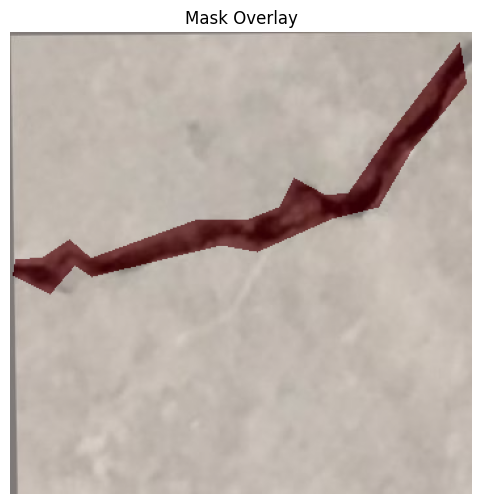

In [ ]:
show_overlay("cracks-1")

### Select GPU (CUDA) if available, otherwise fall back to CPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


### Custom PyTorch Dataset for text-guided image segmentation
 Each sample consists of:
   - an image
   - a text prompt describing the task
   - a binary segmentation mask (ground truth)


In [ ]:
class TextSegDataset(Dataset):
    def __init__(self, dataset_path, split, prompt, processor):
        self.root = Path(dataset_path) / split
        self.images = sorted(
            list(self.root.glob("*.jpg")) +
            list(self.root.glob("*.jpeg")) +
            list(self.root.glob("*.png"))
        )
        self.images = [img for img in self.images if "masks" not in str(img)]

        self.prompt = prompt
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")

        base = img_path.stem
        mask_path = self.root / "masks" / f"{base}.png"

        if mask_path.exists():
            mask = Image.open(mask_path).convert("L")
        else:
            mask = Image.new("L", image.size, 0)
            print(f"⚠️ Warning: No mask found for {img_path.name}")

        if isinstance(self.prompt, list):
            prompt = random.choice(self.prompt)
        else:
            prompt = self.prompt

        inputs = self.processor(
            text=prompt,
            images=image,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # CLIPSeg typically uses 352x352
        mask = mask.resize((352, 352), Image.NEAREST)
        mask = np.array(mask) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return {
            "pixel_values": inputs.pixel_values.squeeze(0),
            "input_ids": inputs.input_ids.squeeze(0),
            "attention_mask": inputs.attention_mask.squeeze(0),
            "labels": mask
        }

### Training Pipeline Overview

1. **Model Setup**
   - Load a pretrained CLIPSeg model for text-guided image segmentation
   - Move the model to the selected computation device (CPU/GPU)

2. **Partial Fine-Tuning Strategy**
   - Freeze most CLIP layers to preserve pretrained representations
   - Unfreeze the last vision encoder layers for task-specific learning
   - Unfreeze the last text encoder layers too
   - Train the segmentation decoder for drywall joint detection

3. **Dataset & Prompt Design**
   - Prepare custom datasets for training and validation
   - Use multiple text prompts during training to improve robustness
   - Use a fixed evaluation prompt for consistent validation

4. **Optimization & Training**
   - Optimize the model using a combined Dice + Binary Cross-Entropy loss
   - Apply different learning rates for decoder and encoder layers
   - Use a Cosine Annealing Learning Rate Scheduler for stable convergence

5. **Evaluation & Metrics**
   - Evaluate segmentation performance using Dice score
   - Measure region overlap using mean Intersection over Union (mIoU)
   - Track training loss, validation metrics, and learning rate across epochs


In [ ]:
MODEL_ID = "CIDAS/clipseg-rd64-refined"

processor = AutoProcessor.from_pretrained(MODEL_ID)
model = CLIPSegForImageSegmentation.from_pretrained(MODEL_ID)
model.to(device)

# Freeze CLIP encoders
for param in model.clip.parameters():
    param.requires_grad = False

# Unfreeze last 2 layers for fine-tuning
for param in model.clip.vision_model.encoder.layers[-2:].parameters():
    param.requires_grad = True

# Unfreeze text encoder last layer too (helps with custom prompts)
for param in model.clip.text_model.encoder.layers[-1:].parameters():
    param.requires_grad = True

print("✅ Model loaded and CLIP partially frozen")

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Trainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

✅ Model loaded and CLIP partially frozen
📊 Trainable: 18,455,137 / 150,747,746 (12.24%)


In [ ]:
DATASET_DIR = "cracks-1"
TRAIN_PROMPTS = [
   "segment crack",
   "segment wall crack",
]

EVAL_PROMPT = "segment crack"

train_ds = TextSegDataset(DATASET_DIR, "train", TRAIN_PROMPTS, processor)
val_ds   = TextSegDataset(DATASET_DIR, "valid", EVAL_PROMPT, processor)

BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")

Train samples: 14145
Val samples:   318
Train batches: 885
Val batches:   20


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss()

pos_weight = torch.tensor([5.0]).to(device)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()



In [ ]:
criterion = FocalLoss(alpha=0.75, gamma=2.0)

optimizer = AdamW([
    {'params': model.decoder.parameters(), 'lr': 5e-5},
    {'params': model.clip.vision_model.encoder.layers[-2:].parameters(), 'lr': 2e-6},
    {'params': model.clip.text_model.encoder.layers[-1:].parameters(), 'lr': 1e-6}
], weight_decay=0.01)

EPOCHS = 15

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

def dice_score(pred, gt):
    """
    Compute Dice score for binary segmentation
    pred, gt: tensors of shape [B, 1, H, W] or [B, H, W]
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Flatten spatial dimensions but keep batch separate
    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    intersection = (pred * gt).sum(dim=1)
    dice = (2 * intersection) / (pred.sum(dim=1) + gt.sum(dim=1) + 1e-6)

    return dice.mean()

def iou_score(pred, gt):
    """
    Compute IoU score for binary segmentation
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    intersection = (pred * gt).sum(dim=1)
    union = (pred + gt).clamp(0, 1).sum(dim=1)
    iou = intersection / (union + 1e-6)

    return iou.mean()

def miou_score(pred, gt):
    """
    Compute mean IoU across both classes (foreground and background)
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    # Foreground IoU
    intersection_fg = (pred * gt).sum(dim=1)
    union_fg = (pred + gt).clamp(0, 1).sum(dim=1)
    iou_fg = intersection_fg / (union_fg + 1e-6)

    # Background IoU
    pred_bg = 1 - pred
    gt_bg = 1 - gt
    intersection_bg = (pred_bg * gt_bg).sum(dim=1)
    union_bg = (pred_bg + gt_bg).clamp(0, 1).sum(dim=1)
    iou_bg = intersection_bg / (union_bg + 1e-6)

    # Mean of both classes
    miou = (iou_fg + iou_bg) / 2

    return miou.mean()


In [ ]:
# Early stopping and model checkpointing
best_dice = 0.0
patience = 5
patience_counter = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': [],
    'val_miou': [],
    'learning_rate': []
}

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    # ADD: Progress bar
    from tqdm import tqdm

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )

        preds = outputs.logits

        # Ensure correct shape: [B, 1, H, W] or [B, H, W]
        if preds.ndim == 3:
            preds = preds.unsqueeze(1)

        labels = batch["labels"].to(device)
        loss = criterion(preds, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Validation
    model.eval()
    val_loss = 0
    dices, ious = [], []

    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )

            preds = outputs.logits
            if preds.ndim == 3:
                preds = preds.unsqueeze(1)

            labels = batch["labels"].to(device)

            # Calculate validation loss
            loss = criterion(preds, labels)
            val_loss += loss.item()

            # Metrics on sigmoid outputs
            preds_sigmoid = torch.sigmoid(preds)

            dice = dice_score(preds_sigmoid, labels)
            miou = miou_score(preds_sigmoid, labels)

            dices.append(dice.item())
            ious.append(miou.item())

    # Store metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_dice = np.mean(dices)
    avg_miou = np.mean(ious)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_dice)
    history['val_miou'].append(avg_miou)
    history['learning_rate'].append(current_lr)

    scheduler.step()

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Dice: {avg_dice:.4f} | "
        f"mIoU: {avg_miou:.4f} | "
        f"LR: {current_lr:.2e}"
    )

    # Model checkpointing
    if avg_dice > best_dice:
        best_dice = avg_dice
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'dice': avg_dice,
            'miou': avg_miou,
        }, 'best_model.pth')
        print(f"💾 Saved best model (Dice: {best_dice:.4f})")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"⚠️ Early stopping triggered after {epoch+1} epochs")
        break

Epoch 1/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 1/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0075]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 1/15 | Train Loss: 0.0186 | Val Loss: 0.0172 | Dice: 0.5813 | mIoU: 0.6971 | LR: 5.00e-05
💾 Saved best model (Dice: 0.5813)


Epoch 2/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 2/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0067]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 2/15 | Train Loss: 0.0159 | Val Loss: 0.0161 | Dice: 0.5915 | mIoU: 0.7040 | LR: 4.95e-05
💾 Saved best model (Dice: 0.5915)


Epoch 3/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 3/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0211]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 3/15 | Train Loss: 0.0149 | Val Loss: 0.0157 | Dice: 0.6035 | mIoU: 0.7107 | LR: 4.78e-05
💾 Saved best model (Dice: 0.6035)


Epoch 4/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 4/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0152]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 4/15 | Train Loss: 0.0142 | Val Loss: 0.0155 | Dice: 0.5974 | mIoU: 0.7083 | LR: 4.52e-05


Epoch 5/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 5/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0507]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 5/15 | Train Loss: 0.0137 | Val Loss: 0.0155 | Dice: 0.6033 | mIoU: 0.7114 | LR: 4.17e-05


Epoch 6/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 6/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0630]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 6/15 | Train Loss: 0.0133 | Val Loss: 0.0155 | Dice: 0.6119 | mIoU: 0.7156 | LR: 3.75e-05
💾 Saved best model (Dice: 0.6119)


Epoch 7/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 7/15: 100%|██████████| 885/885 [08:34<00:00,  1.72it/s, loss=0.0062]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 7/15 | Train Loss: 0.0129 | Val Loss: 0.0156 | Dice: 0.5954 | mIoU: 0.7072 | LR: 3.28e-05


Epoch 8/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 8/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0099]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 8/15 | Train Loss: 0.0127 | Val Loss: 0.0154 | Dice: 0.6031 | mIoU: 0.7115 | LR: 2.77e-05


Epoch 9/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 9/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0116]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argumen

Epoch 9/15 | Train Loss: 0.0125 | Val Loss: 0.0155 | Dice: 0.5978 | mIoU: 0.7089 | LR: 2.24e-05


Epoch 10/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 10/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0073]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argum

Epoch 10/15 | Train Loss: 0.0123 | Val Loss: 0.0154 | Dice: 0.6072 | mIoU: 0.7132 | LR: 1.73e-05


Epoch 11/15:   0%|          | 0/885 [00:00<?, ?it/s]The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
Epoch 11/15: 100%|██████████| 885/885 [08:33<00:00,  1.72it/s, loss=0.0042]
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
The following named argum

Epoch 11/15 | Train Loss: 0.0122 | Val Loss: 0.0154 | Dice: 0.5975 | mIoU: 0.7091 | LR: 1.26e-05
⚠️ Early stopping triggered after 11 epochs


### Plotting Metrics

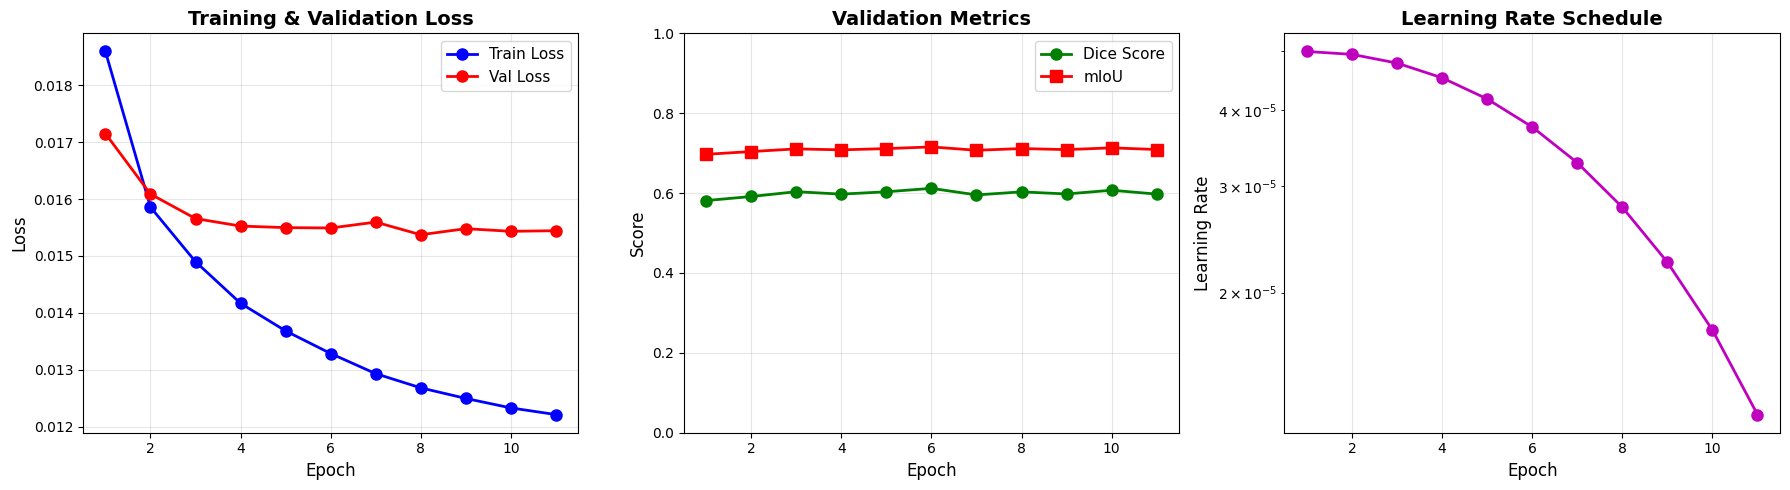


📊 Final Results:
Best Dice Score: 0.6119 at epoch 6
Best mIoU: 0.7156 at epoch 6
Final Train Loss: 0.0122
Final Val Loss: 0.0154


In [ ]:
# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training & Validation Loss
axes[0].plot(range(1, len(history['train_loss'])+1), history['train_loss'],
             'b-o', linewidth=2, markersize=8, label='Train Loss')
axes[0].plot(range(1, len(history['val_loss'])+1), history['val_loss'],
             'r-o', linewidth=2, markersize=8, label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Metrics
axes[1].plot(range(1, len(history['val_dice'])+1), history['val_dice'],
             'g-o', linewidth=2, markersize=8, label='Dice Score')
axes[1].plot(range(1, len(history['val_miou'])+1), history['val_miou'],
             'r-s', linewidth=2, markersize=8, label='mIoU')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Validation Metrics', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# Plot 3: Learning Rate
axes[2].plot(range(1, len(history['learning_rate'])+1), history['learning_rate'],
             'm-o', linewidth=2, markersize=8)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Final Results:")
print(f"Best Dice Score: {max(history['val_dice']):.4f} at epoch {history['val_dice'].index(max(history['val_dice']))+1}")
print(f"Best mIoU: {max(history['val_miou']):.4f} at epoch {history['val_miou'].index(max(history['val_miou']))+1}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")

### Visualize 10 random samples from validation set

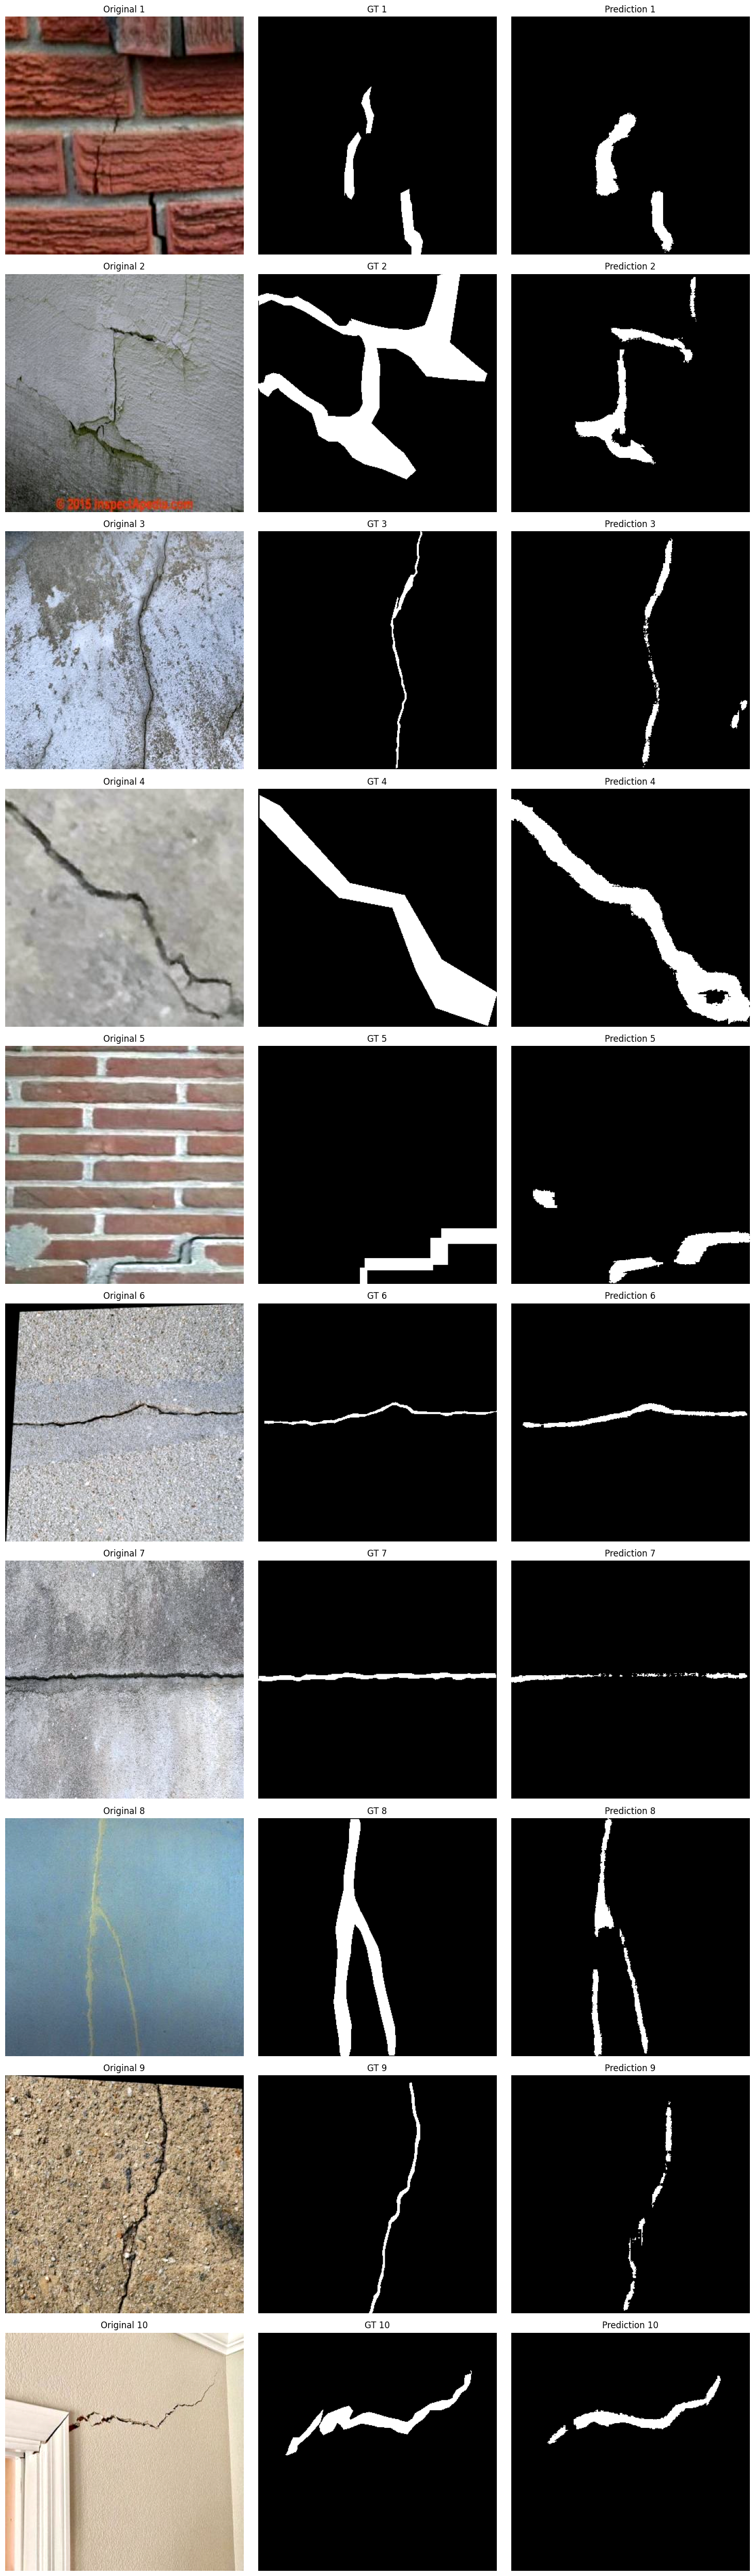

In [ ]:
def denormalize_clip(img):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711])
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)


num_samples = 10
indices = random.sample(range(len(val_ds)), num_samples)

model.eval()

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

with torch.no_grad():
    for i, idx in enumerate(indices):
        item = val_ds[idx]

        # Get prediction
        outputs = model(
            pixel_values=item["pixel_values"].unsqueeze(0).to(device),
            input_ids=item["input_ids"].unsqueeze(0).to(device),
            attention_mask=item["attention_mask"].unsqueeze(0).to(device)
        )

        # Process prediction
        pred = torch.sigmoid(outputs.logits)
        if pred.ndim == 4:
            pred = pred[0, 0]
        else:
            pred = pred[0]
        pred = pred.cpu().numpy()

        # Ground truth
        gt = item["labels"][0].cpu().numpy()

        # De-normalize image
        img = denormalize_clip(item["pixel_values"]).permute(1, 2, 0)

        # Plot row
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt, cmap="gray")
        axes[i, 1].set_title(f"GT {i+1}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred > 0.5, cmap="gray")
        axes[i, 2].set_title(f"Prediction {i+1}")
        axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def show_overlay_prediction(dataset_root_path, model, processor, prompt,
                            subset="valid", alpha=0.5):
    model.eval()
    path = Path(dataset_root_path) / subset
    image_files = list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))

    img_path = random.choice(image_files)
    img = Image.open(img_path).convert("RGB")

    # Prepare input
    inputs = processor(
        text=prompt,
        images=img,
        return_tensors="pt"
    )

    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get prediction mask
    pred = torch.sigmoid(outputs.logits)
    if pred.ndim == 4:
        pred = pred[0, 0]
    else:
        pred = pred[0]

    pred = (pred.cpu().numpy() > 0.5).astype("uint8") * 255

    # Plot overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(pred, cmap="Reds", alpha=alpha)
    plt.title(f"Prediction Overlay\nPrompt: {prompt}")
    plt.axis("off")
    plt.show()


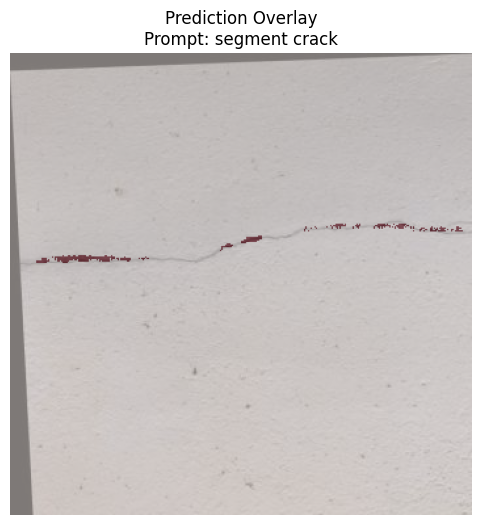

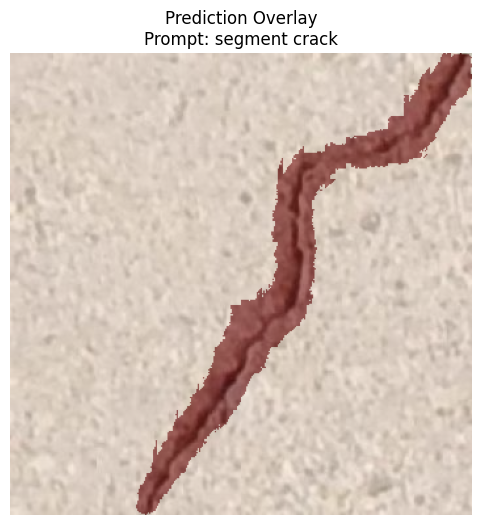

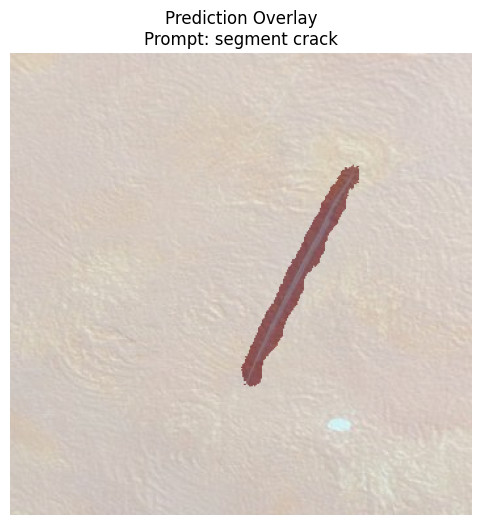

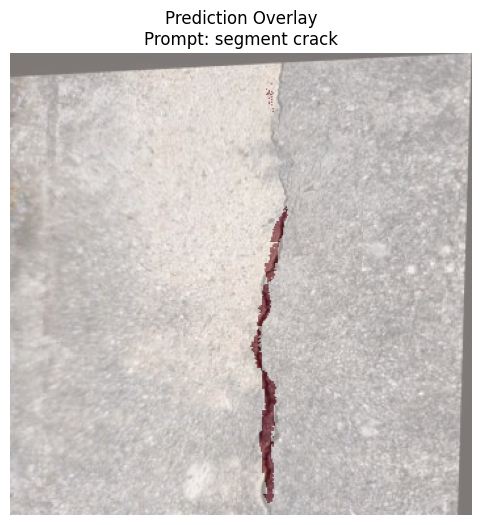

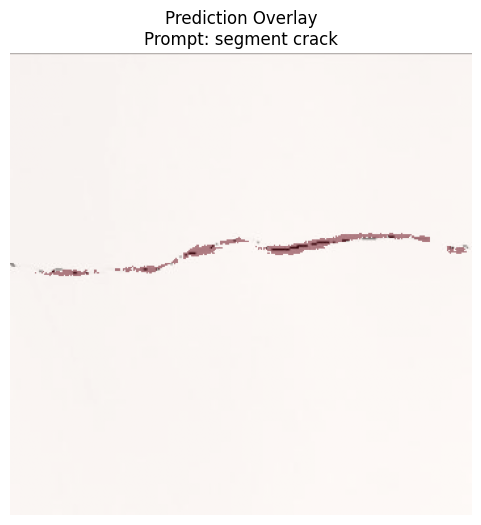

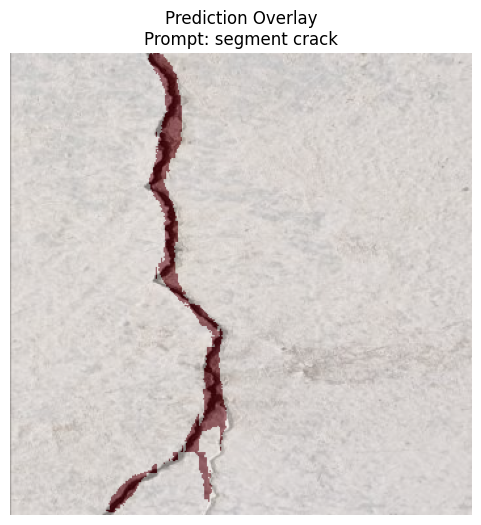

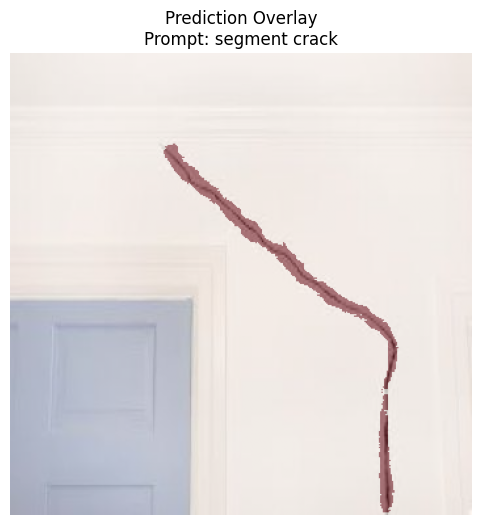

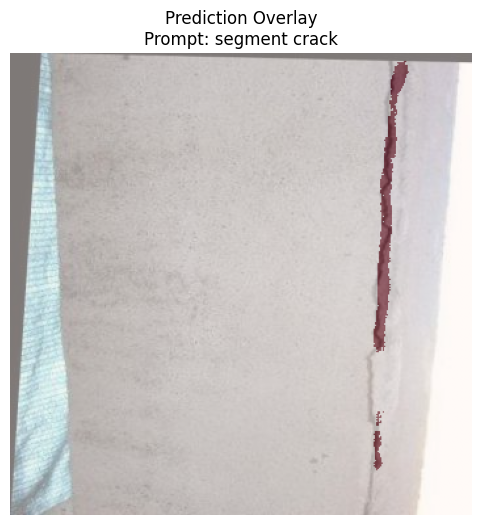

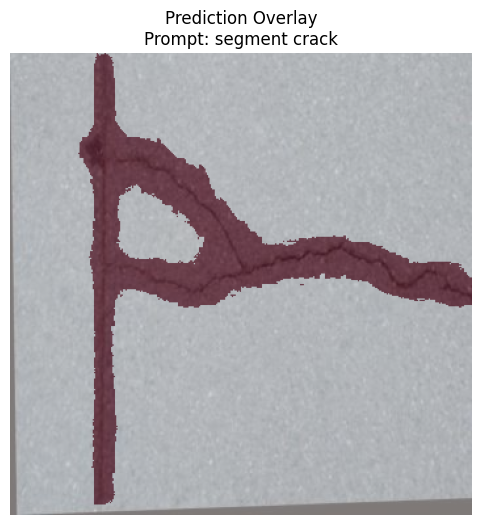

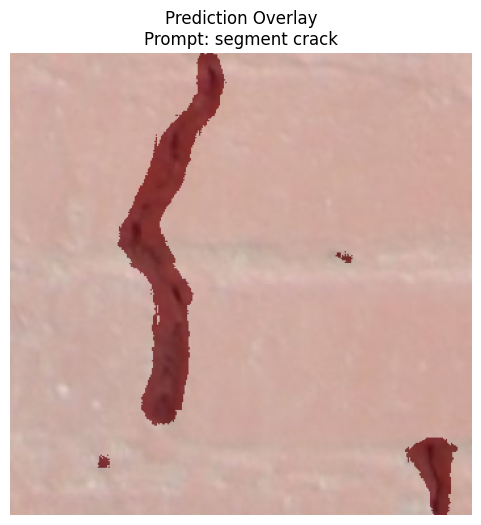

In [ ]:
for i in range(10):
  show_overlay_prediction(
      dataset_root_path=DATASET_DIR,
      model=model,
      processor=processor,
      prompt="segment crack",
      subset="valid"
  )
